In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import keras
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
sys.path.insert(1, '../utils')
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam, SGD
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from utils.declarations import training_files, testing_files, POSE_MAP

In [2]:

num_string = "004"
# ONLY ONE SET
# x_train_wrapper = df_wrapper(training_files[num_string].csv_file)
# x_train_wrapper.concat_sensor_data(3)
# x_train_wrapper.align_poses(training_files[num_string].annot_file, POSE_MAP)

#ADD ALL SETS, except 007 and 008
x_train_arr = []
for i in range(1,10):
    if i == 7 or i == 8:
        pass
    else:
        num_string = "00" + str(i)
        print(num_string)
        elem = df_wrapper(training_files[num_string].csv_file)
        elem.concat_sensor_data(3)
        elem.align_poses(training_files[num_string].annot_file, POSE_MAP)
        x_train_arr.append(elem)

001
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
002
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
003
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [3]:
# ONLY ONE SET
# x_train = x_train_wrapper.df.drop([' TimeStamp (s)', 'Pose'], axis=1)
# y_train = x_train_wrapper.df['Pose']

# ALL TRAINING SETS
x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'], axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

print("x_train shape after drop: ", np.shape(x_train))
print("y_train shape after drop: ", np.shape(y_train))

x_train shape after drop:  (466981, 39)
y_train shape after drop:  (466981,)


In [4]:
testing_csv = testing_files["004"].csv_file
testing_annot = testing_files["004"].annot_file


In [5]:

x_test_wrapper = df_wrapper(testing_csv)
x_test_wrapper.concat_sensor_data(3)
x_test_wrapper.align_poses(testing_annot, POSE_MAP)


y_test = x_test_wrapper.df['Pose']
x_test = x_test_wrapper.df.drop([' TimeStamp (s)', 'Pose'],axis=1)

print("x_test shape after drop: ", np.shape(x_test))
print("y_test shape after drop: ", np.shape(y_test))

..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
x_test shape after drop:  (8367, 39)
y_test shape after drop:  (8367,)


In [6]:
#sns.lineplot(data=x_test_wrapper.df, x=" TimeStamp (s)", y="Pose")

In [7]:
# Create numpy arrays
x_train_numpy = x_train.values
y_train_numpy = y_train.values

x_test_numpy = x_test.values
y_test_numpy = y_test.values

# Hot encode categories into numbers
#y_train = to_categorical(y_train_numpy,9)

print(x_train_numpy.shape)
print(y_train_numpy.shape)

print("TEST")
print(x_test_numpy.shape)
print(y_test_numpy.shape)




(466981, 39)
(466981,)
TEST
(8367, 39)
(8367,)


In [8]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(x_train_numpy)
scaler.fit(x_test_numpy)

RobustScaler()

In [9]:

from scipy import stats

NUM_TIMESTAMPS = 100

def create_3d_array(array, num_timestamps):

    arr_3d = []
    temp_2d = []
    for i in range(1,len(array)):
        temp_2d.append(array[i])
        if i % NUM_TIMESTAMPS == 0:
            arr_3d.append(temp_2d)
            temp_2d = []
    
    return arr_3d

def create_2d_y_array(array, num_timestamps):
    arr_2d_y_train = []
    temp_y_train = []
    mode_arr = []

    for i in range(1,len(array)):
        #temp_2d.append(array[0])
        temp_y_train.append(array[i])
        if i % NUM_TIMESTAMPS == 0:
            mode_arr.append(temp_y_train)

            temp_y_train = []
            #temp_2d = []

    y_train_to_be_encoded = []

    for i in range(len(mode_arr)):
        mode = stats.mode(mode_arr[i])
        y_train_to_be_encoded.append(mode.mode[0])

    #ONE HOT ENCODING
    encoding = []
    for value in y_train_to_be_encoded:
        vector = [0 for _ in range(9)]
        vector[value] = 1
        encoding.append(vector)
    
    return np.array(encoding)




In [10]:

x_train = np.array(create_3d_array(x_train_numpy, NUM_TIMESTAMPS))
y_train = np.array(create_2d_y_array(y_train_numpy, NUM_TIMESTAMPS))

x_test = np.array(create_3d_array(x_test_numpy, NUM_TIMESTAMPS))
y_test = np.array(create_2d_y_array(y_test_numpy, NUM_TIMESTAMPS))
print(np.shape(x_train))
print(np.shape(y_train))


(4669, 100, 39)
(4669, 9)


In [11]:

print(np.shape(x_test))

(83, 100, 39)


In [38]:
from keras.layers import LSTM
from tensorflow.keras import layers

OPTIM = Adam(learning_rate=0.00005)

model = Sequential()
model.add(LSTM(1024, activation='sigmoid', return_sequences=True, input_shape=[x_train.shape[1], x_train.shape[2]]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(700, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(LSTM(100, activation='sigmoid', input_shape=[x_train.shape[1], x_train.shape[2]]))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer=OPTIM,  loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [39]:

#model.fit(x=np.array(arr_3d_x_train), batch_size=512, y=y_train, shuffle=False, epochs=10)

model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, validation_data=(x_test,y_test))
#model.reset_states()



Epoch 1/10
146/146 [==============================] - 386s 3s/step - loss: 2.1356 - accuracy: 0.2140 - val_loss: 1.1915 - val_accuracy: 0.7711
Epoch 2/10
146/146 [==============================] - 396s 3s/step - loss: 0.8304 - accuracy: 0.9113 - val_loss: 0.3715 - val_accuracy: 0.9639
Epoch 3/10
146/146 [==============================] - 378s 3s/step - loss: 0.2301 - accuracy: 0.9881 - val_loss: 0.2990 - val_accuracy: 0.8916
Epoch 4/10
146/146 [==============================] - 399s 3s/step - loss: 0.1399 - accuracy: 0.9854 - val_loss: 0.2910 - val_accuracy: 0.8795
Epoch 5/10
146/146 [==============================] - 395s 3s/step - loss: 0.1030 - accuracy: 0.9885 - val_loss: 0.2952 - val_accuracy: 0.9639
Epoch 6/10
146/146 [==============================] - 374s 3s/step - loss: 0.0818 - accuracy: 0.9898 - val_loss: 0.2898 - val_accuracy: 0.8916
Epoch 7/10
146/146 [==============================] - 363s 2s/step - loss: 0.0667 - accuracy: 0.9923 - val_loss: 0.2888 - val_accuracy: 0.8795

In [6]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.plot()
plt.title('accuracy, val_acc, loss, val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_arrucary', 'loss', 'val_loss'], loc='upper right')
plt.ylim(top=2)
axes=plt.gca()

plt.show()

NameError: name 'plt' is not defined

In [41]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_test)
model.evaluate(x_test,y_test)


3/3 [==============================] - 1s 446ms/step - loss: 0.3002 - accuracy: 0.8795


[0.300163209438324, 0.8795180916786194]

<AxesSubplot:>

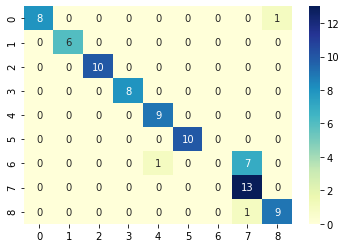

In [42]:
y_test_1d = []
predictions_1d = []
for i in range(len(y_test)):
    y_test_1d.append(np.argmax(y_test[i]))
    predictions_1d.append(np.argmax(predictions[i]))

sns.heatmap(data=confusion_matrix(y_test_1d,predictions_1d), cmap="YlGnBu", annot=True)

In [43]:
#model.save("RNN-LSTM_1bs_50hz.h5")

In [44]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(3)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test_it = elem.df["Pose"]
    elem.df = elem.df.drop([' TimeStamp (s)', 'Pose'],axis=1)
    print(np.shape(elem.df))
    # y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = np.array(create_3d_array(np.array(elem.df), NUM_TIMESTAMPS))
    y_test_dict[key] = np.array(create_2d_y_array(np.array(y_test_it), NUM_TIMESTAMPS))
    print(np.shape(x_test_dict[key]))
    print(np.shape(y_test_dict[key]))

#x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
#y_test = y_test_dict[VALIDATION_TESTSET]

..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
(4039, 39)
(40, 100, 39)
(40, 9)
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
(8367, 39)
(83, 100, 39)
(83, 9)
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [45]:
print("Classification accuracy:")
classification_dict = dict()

for key in x_test_dict:
    #x_test = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
    classifications = model.predict(x_test_dict[key])
    model.evaluate(x_test_dict[key], y_test_dict[key])
    #classification_dict[key] = classifications

Classification accuracy:
3/3 [==============================] - 1s 434ms/step - loss: 0.6460 - accuracy: 0.8077
